In [1]:
!pip install --upgrade pip
!pip install matplotlib
!pip install pillow==6.2.2

Requirement already up-to-date: pip in ./venv/lib/python3.5/site-packages (20.0.2)


In [2]:
import numpy as np
import dlib
import cv2
import argparse
import os
from image_utility import save_image, generate_random_color, draw_border
from imutils import face_utils
import copy

import matplotlib.pyplot as plt

import mask

%load_ext autoreload
%autoreload 2

In [3]:
WEIGHTS = mask.WEIGHTS
MODEL = mask.MODEL

In [4]:
face_detector = mask.face_detector

model = MODEL
predictor = mask.predictor

In [80]:
img = 'suhail_1.jpg'
image = cv2.imread(img)

In [81]:
# plt.imshow(image[:, :, [2, 1, 0]]) # BGR
# plt.show()

In [82]:
landmarks = mask.face_detection(image)

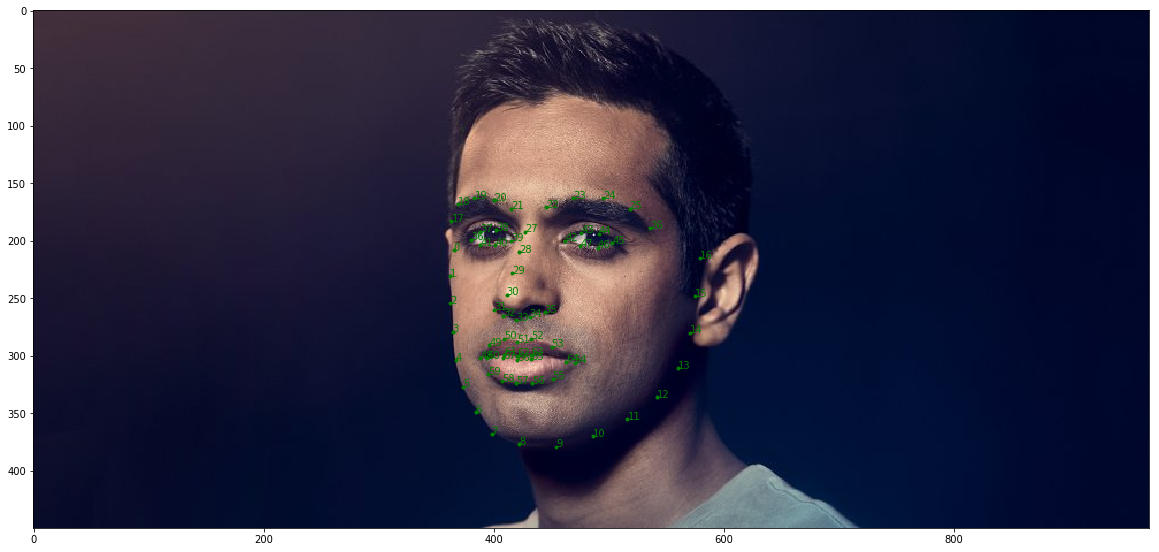

In [83]:
plt.figure(figsize=(20,20))
plt.imshow(image[:, :, [2, 1, 0]]) # BGR

for i, (x,y) in enumerate(landmarks[0]):
    plt.plot(x,y, '.g')
    plt.text(x,y, str(i), color='g')
    
plt.show()

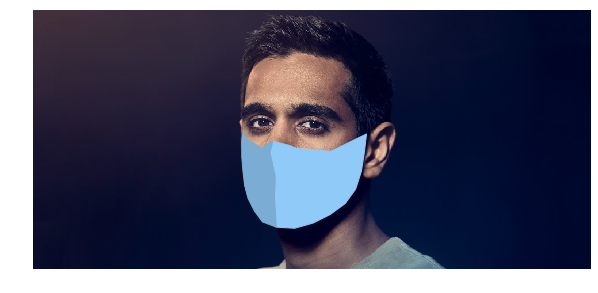

In [90]:
img = 'suhail_1.jpg'
image = cv2.imread(img)

landmarks = mask.face_detection(image)
left_mask, right_mask = mask.build_mask(landmarks[0])

fig = plt.figure(figsize=(10,10))
plt.imshow(image[:, :, [2, 1, 0]]) # BGR

plt.fill(right_mask[:,0], right_mask[:,1], color=np.array([144, 202, 249])/255 )
plt.fill(left_mask[:,0], left_mask[:,1], color=np.array([144, 202, 249])/300 )

plt.axis('off')
plt.savefig('test.jpg', fig=fig, format='jpeg')

    
plt.show()

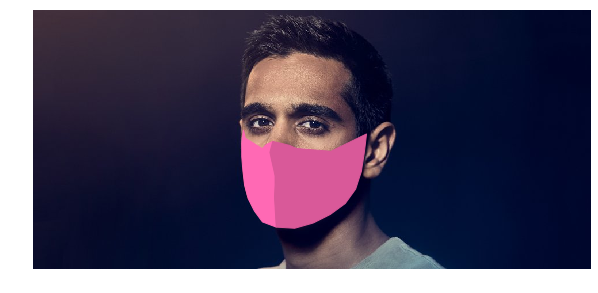

In [92]:
res = mask.impose_mask('suhail_1.jpg', 'suhail_1_mask.jpg')

In [11]:
res['image'].shape

(1328, 1330, 3)

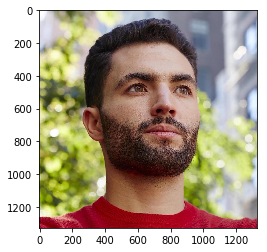

In [12]:
plt.imshow(res['image'])

In [13]:
from PIL import Image, ImageDraw

In [54]:
def get_brightness(src):
    R = src[:,:,0]
    G = src[:,:,1]
    B = src[:,:,2]

    return (0.375*R + 0.5*G + 0.125*B)

def update_with_brightness(m, y):
    m = copy.deepcopy(m)
    for i in range(m.shape[2]):
        m[:,:,i] = 0.9*m[:,:,i] + 0.1*m[:,:,i]*y
    return m

def generate_polygon_mask(src, mask_coords):
    img = Image.new('L', (src.shape[1], src.shape[0]), 0)
    for mc in mask_coords:
        ImageDraw.Draw(img).polygon(list(map(tuple, mc.astype(int))), outline=1, fill=1)
    pmask = np.array(img).astype(float)
    return pmask

def add_alpha_layer(m):
    return np.dstack([m, np.ones(m.shape[:2]).astype(m.dtype)])

In [61]:
src = res['image']
overlay = np.array(Image.open('pink_cloth.jpg').resize(src.shape[1::-1], Image.BILINEAR))
masks = res['masks']

In [62]:
# Convert to float
src = src.astype(float)/255
overlay = overlay.astype(float)/255

In [63]:
overlay_brightness = update_with_brightness(overlay, get_brightness(src))
overlay_brightness_alpha = add_alpha_layer(overlay_brightness)
src_alpha = add_alpha_layer(src)

In [64]:
pmask = generate_polygon_mask(src, masks) # polygon mask, representing the mask

overlay_brightness_alpha[:,:,3] = overlay_brightness_alpha[:,:,3]*pmask
src_alpha[:,:,3] = src_alpha[:,:,3]*(1-pmask)

In [71]:
def alpha_blend(x,y):
    x = copy.deepcopy(x)
    y = copy.deepcopy(y)
    for i in range(3):
        x[:,:,i] = x[:,:,i]*x[:,:,3]
        y[:,:,i] = y[:,:,i]*y[:,:,3]
        
    return x + y

In [72]:
composed = alpha_blend(overlay_brightness_alpha, src_alpha)

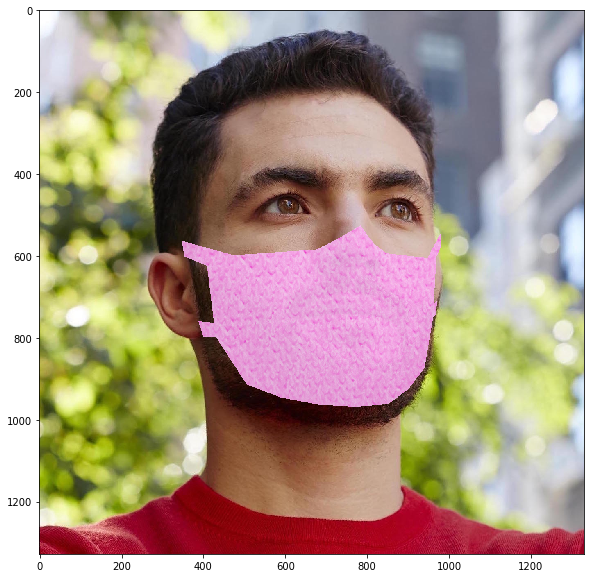

In [75]:
plt.figure(figsize=(10,10))
plt.imshow(composed)

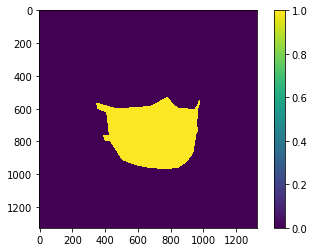

In [46]:
plt.imshow(pmask)
plt.colorbar()

In [48]:
overlay_brightness_alpha.shape

(1328, 1330, 4)

In [ ]:
plt.imshow(generate_polygon_mask(src, res['masks']))

In [ ]:
plt.imshow(src)

In [ ]:
def hsv_to_hsl(hsv):
    im = np.zeros(hsv.shape, dtype=hsv.dtype)
    
    im[:,:,0] = hsv[:,:,0]
    im[:,:,1] = hsv[:,:,2]*(1 - hsv[:,:,1]/2)
    im[:,:,2] = (hsv[:,:,2] - im[:,:,1])/np.minimum(im[:,:,1], 1-im[:,:,1])
    
    im[:,:,2][np.logical_or(im[:,:,1]==0,im[:,:,1]==1)] = 0
    
    im = im[:, :, [0, 2, 1]]
    
    return im

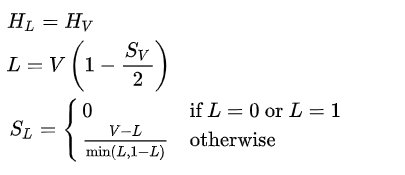

In [ ]:
src_hsv = cv2.cvtColor(src, cv2.COLOR_BGR2HSV)
src_hsl = hsv_to_hsl(src_hsv)

In [ ]:
plt.imshow(src_hsl[:,:,0])
plt.colorbar()